In [3]:
import math
import numpy as np
import copy
import itertools
import time

In [2]:
# simplification
def f(L, maxl, cost, k, B):
    if k == 1:
        return ([L], B*max(0, L-maxl))
    if k == L:
        cost_ = max(1, maxl) * B
        for i in range(k-1):
         #   cost_ += cost[i][i]
            cost_ += cost[i]
        return ([1] * L, cost_)
    
    cost_best = float("inf")
    S_best = []
    for i in reversed(range(k, L)):
        S, cost_ = f(i, max(L-i, maxl), cost, k-1, B)
        cost_ += max(0, L-i-maxl)*B
        cost_ += cost[i-1]
        if cost_ < cost_best:
            cost_best = cost_
            S.append(L-i)
            S_best = S
    return S_best, cost_best

In [3]:
L = 12
k = 8
cost = [2,1,1,3] * 12
f(L, 0, cost, k, 3)

([2, 1, 2, 2, 2, 1, 1, 1], 15)

In [39]:
def pipe_dp(L, cost_e, cost_c, k, B):
    # Generate all possible max length
    possible = [0]
    
    for i in range(1, L+1):
        ptr = 0
        while ptr + i <= L:
            possible.append(sum(cost_e[ptr:ptr+i]))
            ptr += 1
    
    possible = sorted(list(set(possible)))
    # print(possible)
    # trace will be a 3D list
    trace = []
    for i in range(L):
        outer = []
        for j in range(k):
            inner = []
            for m in range(len(possible)):
                inner.append(([],np.infty))
            outer.append(inner)
        trace.append(outer)
    
    # i: layer id, starting from 0
    # j: number of cut (=GPU-1)
    for i in range(L):
        for j in range(k):
            for m in range(len(possible)):
                if i+1 <= j: # invalid
                    pass
                else:
                    if j == 0: # base case: 0 cut
                        cur_sum = sum(cost_e[:i+1])
                        assert cur_sum in possible
                        trace[i][j][m] = ([i+1], (B-1) * max(0, cur_sum - possible[m]))
                    else:
                        cost_best = np.infty
                        S_best = []
                        for cut in range(j-1, i):
                            cur_sum = sum(cost_e[cut+1:i+1])
                            assert cur_sum in possible
                            S, cost_ = trace[cut][j-1][possible.index(max(cur_sum, possible[m]))]
                            #print(S, cost_)
                            cost_ += (B-1) * max(0, cur_sum - possible[m])
                            cost_ += cost_c[cut][j-1]
                            if cost_ < cost_best:
                                cost_best = cost_
                                S_ = copy.deepcopy(S)
                                S_.append(i-cut)
                                S_best = S_
                        trace[i][j][m] = (S_best, cost_best)
                        
    for i in range(L):
        for j in range(k):
            pass
            #print(i, j, trace[i][j])
    return trace[L-1][k-1][0]

def brute_force(L, cost_e, cost_c, k, B):
    best_S = []
    best_cost = np.infty
    ptr_done = [0] * (k-1)
    possible = list(itertools.combinations(range(L-1), k-1))
    for p in possible:
        p = list(p)
        p.append(L-1)
        lens = [sum(cost_e[:p[0]+1])]
        s = [p[0]+1]
        for i in range(len(p)-1):
            lens.append(sum(cost_e[p[i]+1:p[i+1]+1]))
            s.append(p[i+1]-p[i])     
        max_l = max(lens)
        cost = (B-1) * max_l
        for i in range(k-1):
            cost += cost_c[p[i]][i]
        if cost < best_cost:
            best_cost = cost
            best_S = s
    return best_S, best_cost

def uniform_split(L, cost_e, cost_c, k, B):
    per_stage = L // k
    
    s = [per_stage] * (k-1)
    s.append(L-sum(s))
    p = [s[0]-1]
    for i in range(1, k):
        p.append(p[i-1] + s[i])
    lens = [sum(cost_e[:p[0]+1])]
    for i in range(len(s)-1):
        lens.append(sum(cost_e[p[i]+1:p[i+1]+1]))
    max_l = max(lens)
    cost = (B-1) * max_l
    for i in range(k-1):
        cost += cost_c[p[i]][i]
    return s, cost

In [40]:
L = 4
k = 2
cost_e = [1,3,2,5]
cost_c = np.ones((L-1, k-1)) * 2
pipe_dp(L, cost_e, cost_c, k, 3)

([3, 1], 14.0)

In [6]:
test_list = [(12, 4), (24, 4), (24,8), (24, 12), (36, 8)]

In [7]:
# homogeneous test
for L, k in test_list:
    cost_e = np.ones(L)
    cost_c = np.ones((L-1, k-1)) * 2
    time_s = time.time()
    res = pipe_dp(L, cost_e, cost_c, k, 3)
    print(f"homo dp L={L} k={k} is {res[0]}, minimum cost {res[1]}. Took time {time.time() - time_s}")
    time_s = time.time()
    res = brute_force(L, cost_e, cost_c, k, 3)
    print(f"homo bf L={L} k={k} is {res[0]}, minimum cost {res[1]}. Took time {time.time() - time_s}")
    time_s = time.time()
    res = uniform_split(L, cost_e, cost_c, k, 3)
    print(f"homo us L={L} k={k} is {res[0]}, minimum cost {res[1]}. Took time {time.time() - time_s}")

homo dp L=12 k=4 is [3, 3, 3, 3], minimum cost 12.0. Took time 0.011992931365966797
homo bf L=12 k=4 is [3, 3, 3, 3], minimum cost 12.0. Took time 0.0019693374633789062
homo us L=12 k=4 is [3, 3, 3, 3], minimum cost 12.0. Took time 0.0
homo dp L=24 k=4 is [6, 6, 6, 6], minimum cost 18.0. Took time 0.10870838165283203
homo bf L=24 k=4 is [6, 6, 6, 6], minimum cost 18.0. Took time 0.01897430419921875
homo us L=24 k=4 is [6, 6, 6, 6], minimum cost 18.0. Took time 0.0
homo dp L=24 k=8 is [3, 3, 3, 3, 3, 3, 3, 3], minimum cost 20.0. Took time 0.217421293258667
homo bf L=24 k=8 is [3, 3, 3, 3, 3, 3, 3, 3], minimum cost 20.0. Took time 4.393254518508911
homo us L=24 k=8 is [3, 3, 3, 3, 3, 3, 3, 3], minimum cost 20.0. Took time 0.0
homo dp L=24 k=12 is [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], minimum cost 26.0. Took time 0.285236120223999
homo bf L=24 k=12 is [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], minimum cost 26.0. Took time 33.23172187805176
homo us L=24 k=12 is [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [8]:
# hetergeneous test
for L, k in test_list:
    cost_e = np.random.randint(low=5,high=10,size=L)
    cost_c = np.random.randint(low=5,high=10,size=(L-1,k-1))
    time_s = time.time()
    res = pipe_dp(L, cost_e, cost_c, k, 3)
    print(f"hete dp L={L} k={k} is {res[0]}, minimum cost {res[1]}. Took time {time.time() - time_s}")
    time_s = time.time()
    res = brute_force(L, cost_e, cost_c, k, 3)
    print(f"hete bf L={L} k={k} is {res[0]}, minimum cost {res[1]}. Took time {time.time() - time_s}")
    time_s = time.time()
    res = uniform_split(L, cost_e, cost_c, k, 3)
    print(f"hete us L={L} k={k} is {res[0]}, minimum cost {res[1]}. Took time {time.time() - time_s}")

hete dp L=12 k=4 is [3, 3, 3, 3], minimum cost 65. Took time 0.05385589599609375
hete bf L=12 k=4 is [3, 3, 3, 3], minimum cost 65. Took time 0.0019943714141845703
hete us L=12 k=4 is [3, 3, 3, 3], minimum cost 65. Took time 0.0
hete dp L=24 k=4 is [6, 6, 6, 6], minimum cost 106. Took time 0.7928957939147949
hete bf L=24 k=4 is [6, 6, 6, 6], minimum cost 106. Took time 0.019946575164794922
hete us L=24 k=4 is [6, 6, 6, 6], minimum cost 106. Took time 0.0
hete dp L=24 k=8 is [4, 4, 3, 3, 3, 3, 3, 1], minimum cost 94. Took time 1.6836636066436768
hete bf L=24 k=8 is [4, 4, 3, 3, 3, 3, 3, 1], minimum cost 94. Took time 4.632146120071411
hete us L=24 k=8 is [3, 3, 3, 3, 3, 3, 3, 3], minimum cost 99. Took time 0.0
hete dp L=24 k=12 is [3, 3, 2, 2, 2, 3, 2, 2, 2, 1, 1, 1], minimum cost 107. Took time 2.1664862632751465
hete bf L=24 k=12 is [3, 3, 2, 2, 2, 3, 2, 2, 2, 1, 1, 1], minimum cost 107. Took time 35.20006608963013
hete us L=24 k=12 is [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], minimum cos

In [9]:
test_list_large = [(12, 4), (24, 12), (36, 8), (36, 12), (48,12), (48, 24), (64, 12), (64, 16), (128, 32), (128, 12), (128, 50)]
for L, k in test_list_large:
    cost_e = np.random.randint(low=5,high=10,size=L)
    cost_c = np.random.randint(low=5,high=10,size=(L-1,k-1))
    time_s = time.time()
    res = pipe_dp(L, cost_e, cost_c, k, 3)
    print(f"hete dp L={L} k={k} is {res[0]}, minimum cost {res[1]}. Took time {time.time() - time_s}")
    time_s = time.time()
    res = uniform_split(L, cost_e, cost_c, k, 3)
    print(f"hete us L={L} k={k} is {res[0]}, minimum cost {res[1]}. Took time {time.time() - time_s}")

hete dp L=12 k=4 is [3, 3, 3, 3], minimum cost 63. Took time 0.04787135124206543
hete us L=12 k=4 is [3, 3, 3, 3], minimum cost 63. Took time 0.0
hete dp L=24 k=12 is [2, 3, 2, 2, 2, 2, 3, 1, 3, 1, 2, 1], minimum cost 104. Took time 2.271606683731079
hete us L=24 k=12 is [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], minimum cost 115. Took time 0.0
hete dp L=36 k=8 is [4, 4, 5, 5, 4, 4, 5, 5], minimum cost 116. Took time 8.569116592407227
hete us L=36 k=8 is [4, 4, 4, 4, 4, 4, 4, 8], minimum cost 161. Took time 0.0
hete dp L=36 k=12 is [4, 2, 3, 2, 3, 2, 1, 3, 4, 4, 4, 4], minimum cost 117. Took time 11.45845103263855
hete us L=36 k=12 is [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], minimum cost 127. Took time 0.0009965896606445312
hete dp L=48 k=12 is [5, 4, 5, 4, 4, 4, 4, 3, 4, 4, 4, 3], minimum cost 131. Took time 34.14175534248352
hete us L=48 k=12 is [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], minimum cost 154. Took time 0.0
hete dp L=48 k=24 is [2, 1, 1, 2, 3, 3, 3, 1, 3, 3, 1, 3, 2, 2, 3, 2, 2, 3, 1,

In [10]:
from matplotlib import pyplot as plt

test_list = [(16,8), (17, 8), (18,8), (19,8), (20, 8), (21,8), (22,8), (23, 8),(24,8)]
dp_time = []
bf_time = []

# homogeneous test
for L, k in test_list:
    cost_e = np.ones(L)
    cost_c = np.ones((L-1, k-1)) * 2
    time_s = time.time()
    res = pipe_dp(L, cost_e, cost_c, k, 3)
    time_elapsed = time.time() - time_s
    dp_time.append(time_elapsed)
    print(f"homo dp L={L} k={k} is {res[0]}, minimum cost {res[1]}. Took time {time_elapsed}")
    time_s = time.time()
    res = brute_force(L, cost_e, cost_c, k, 3)
    time_elapsed = time.time() - time_s
    bf_time.append(time_elapsed)
    print(f"homo bf L={L} k={k} is {res[0]}, minimum cost {res[1]}. Took time {time_elapsed}")

homo dp L=16 k=8 is [2, 2, 2, 2, 2, 2, 2, 2], minimum cost 18.0. Took time 0.05241870880126953
homo bf L=16 k=8 is [2, 2, 2, 2, 2, 2, 2, 2], minimum cost 18.0. Took time 0.10375094413757324
homo dp L=17 k=8 is [1, 1, 1, 2, 3, 3, 3, 3], minimum cost 20.0. Took time 0.0628042221069336
homo bf L=17 k=8 is [1, 1, 1, 2, 3, 3, 3, 3], minimum cost 20.0. Took time 0.18851900100708008
homo dp L=18 k=8 is [1, 1, 1, 3, 3, 3, 3, 3], minimum cost 20.0. Took time 0.07878994941711426
homo bf L=18 k=8 is [1, 1, 1, 3, 3, 3, 3, 3], minimum cost 20.0. Took time 0.3321406841278076
homo dp L=19 k=8 is [1, 1, 2, 3, 3, 3, 3, 3], minimum cost 20.0. Took time 0.09574341773986816
homo bf L=19 k=8 is [1, 1, 2, 3, 3, 3, 3, 3], minimum cost 20.0. Took time 0.5467679500579834
homo dp L=20 k=8 is [1, 1, 3, 3, 3, 3, 3, 3], minimum cost 20.0. Took time 0.11565995216369629
homo bf L=20 k=8 is [1, 1, 3, 3, 3, 3, 3, 3], minimum cost 20.0. Took time 0.8681454658508301
homo dp L=21 k=8 is [1, 2, 3, 3, 3, 3, 3, 3], minimum 

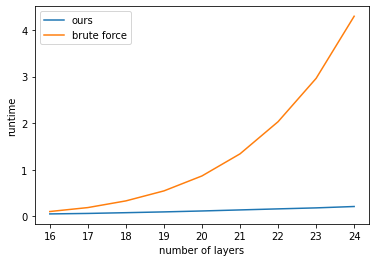

In [11]:
plt.plot([16,17, 18, 19, 20, 21, 22, 23, 24], dp_time, label="ours")
plt.plot([16,17, 18, 19, 20, 21, 22, 23, 24], bf_time, label="brute force")
plt.xlabel("number of layers")
plt.ylabel("runtime")
plt.legend(loc="best")

In [63]:
def draw_fill(puzzle, patternLength, patternWidth, start, count, solList):
    count += 1
    puzzleLength, puzzleWidth = puzzle.shape
    patternNum = (puzzleWidth*puzzleLength)/(patternWidth*patternLength)
    
    horizonal = False
    if start[0] + patternLength <= puzzleLength and start[1] + patternWidth <= puzzleWidth:
        horizonal = True
        #if (puzzle[start[0]:start[0]+patternLength, start[1]:start[1]+patternWidth] != 0).any():
        for i in range(start[0], start[0]+patternLength):
             for j in range(start[1], start[1]+patternWidth):
                 if puzzle[i][j] != 0:
                     horizonal = False
    if horizonal:
        newPuzzle = copy.deepcopy(puzzle)
        for i in range(start[0], start[0]+patternLength):
            for j in range(start[1], start[1]+patternWidth):
                newPuzzle[i][j] = count
        if count == patternNum:
            solList.append(newPuzzle)
            return
        for i in range(start[0], puzzleLength):
            for j in range(0, puzzleWidth):
                if newPuzzle[i][j] == 0:
                    newStart = (i, j)
                    break
            else:
                continue
            break
        draw_fill(newPuzzle, patternLength, patternWidth, newStart, count, solList)

    vertical = False
    if patternLength != patternWidth and start[0]+patternWidth <= puzzleLength and start[1]+patternLength <= puzzleWidth:
        vertical = True
        for i in range(start[0], start[0]+patternWidth):
            for j in range(start[1], start[1]+patternLength):
                if puzzle[i][j] != 0:
                    vertical = False
    if vertical:
        newPuzzle = copy.deepcopy(puzzle)
        for i in range(start[0], start[0]+patternWidth):
            for j in range(start[1], start[1]+patternLength):
                newPuzzle[i][j] = count
        if count == patternNum:
            solList.append(newPuzzle)
            return
        for i in range(start[0], puzzleLength):
            for j in range(0, puzzleWidth):
                if newPuzzle[i][j] == 0:
                    newStart = (i, j)
                    break
            else:
                continue
            break
        draw_fill(newPuzzle, patternLength, patternWidth, newStart, count, solList)

def backtrack(puzzleLength, puzzleWidth, patternLength, patternWidth):
    patternNum = (puzzleWidth*puzzleLength)/(patternWidth*patternLength)
    solList = []
    if patternNum%1 == 0:
        inputPuzzle = np.zeros((puzzleLength, puzzleWidth))
        draw_fill(inputPuzzle, patternLength, patternWidth, (0, 0), 0, solList)
    #solList = np.asarray(solList).reshape((puzzleLength, puzzleWidth))
    return solList

In [76]:
def get_cost_c(conf, L, cluster_info=None):
    # homogeneous setting; in real setting, we access cluster to get cost_c
    num_stages = int(np.max(conf))
    stage_cost = []
    for i in range(1, num_stages):
        b = np.where(conf == i)
        c = np.where(conf == i+1)
        # All pairs of GPU in the same node
        if (b[1] == c[1]).all():
            stage_cost.append(0)
        else:
            stage_cost.append(1)
    stage_cost = np.asarray(stage_cost).reshape((1,-1))
    ret = copy.deepcopy(stage_cost)
    for i in range(L-1):
        ret = np.concatenate((ret, stage_cost), axis=0)
    return ret

def get_cost_e(conf, L, cluster_info=None):
    # homogeneous setting; in real setting, we access cluster to get cost_e
    # return amp_simulator()
    #print(conf.shape[0] * conf.shape[1])
    num_gpus_per_pipeline = conf.shape[0] * conf.shape[1] / np.max(conf)
    return np.ones(L) / num_gpus_per_pipeline

def generate_initial(M, N, threads=2):
    h_w_list = []
    
    h_w_list.append((M, 1))
    h_w_list.append((1, N))
    known = {}
    
    configs = []
    for (h, w) in h_w_list:
        solution = backtrack(M, N, h, w)
        
        assert len(solution) > 0
        config_idx = np.random.choice(len(solution), size=1)[0]
        config = solution[config_idx]
        configs.append(config)
        
        solution.pop(config_idx)
        
        known[(h, w)] = solution
        
    #print(np.asarray(configs[0]))
    return h_w_list, configs, known
    

def cool_down(iter, max_iter, init_temp):
    return init_temp * (1 - iter / max_iter)

def neighbor(cur, known, M, N, maximum_try = 10):
    h, w = cur
    
    time_s = time.time()
    while time.time() - time_s < 10:
        index = np.random.choice([0,1], size=1)[0]
        if index == 0:
            valid = []
            upper = min(M, N)
            upper = min((M*N) // w, upper) + 1
            
            for i in range(1, upper):
                if (i, w) in known.keys():
                    solution = known[(i, w)]
                else:
                    solution = backtrack(M, N, i, w)
                    known[(i, w)] = solution

                if len(solution) > 0:
                    valid.append(i)

            if len(valid) == 0:
                continue
                #return
                
            new_h = np.random.choice(valid, size=1)[0]
            
            # TODO
            new_config_idx = np.random.choice(len(known[(new_h, w)]), size=1)[0]
            ret = known[(new_h, w)].pop(new_config_idx)
            return new_h, w, ret

        else:
            valid = []
            upper = min(M, N)
            upper = min((M*N) // h, upper) + 1
            for i in range(1, upper):
                if (h, i) in known.keys():
                    solution = known[(h, i)]
                else:
                    solution = backtrack(M, N, h, i)
                    known[(h, i)] = solution

                if len(solution) > 0:
                    valid.append(i)

            if len(valid) == 0:
                continue

            new_w = np.random.choice(valid, size=1)[0]
            new_config_idx = np.random.choice(len(known[(h, new_w)]), size=1)[0]
            ret = known[(h, new_w)].pop(new_config_idx)  
            return h, new_w, ret
    return None
    
def predict(configs, L, B):
    costs = []
    for i in range(len(configs)):
        config = configs[i]
        config = np.asarray(config)
        #config = config.reshape((config.shape[0], config.shape[2]))
        cost_e = get_cost_e(config, L)
        cost_c = get_cost_c(config, L)
        k = int(np.max(config))
        cost = pipe_dp(L, cost_e, cost_c, k, B)[1]
        costs.append(cost)
    return np.asarray(costs)

# number of GPU per node
M = 8
# 
N = 4
num_iter = 500
init_t = 1

# 16 layers network, 3 macro-batches
L = 16
B = 3

h_w, configs, known = generate_initial(M, N)
costs = predict(configs, L, B)

for i in range(num_iter):
    cur_t = cool_down(i, num_iter, init_t)   
    
    new_configs = []
    new_h_w = []
    
    for (h, w) in h_w:
        step = neighbor((h, w), known, M, N)
        if step is None:
            new_h, new_w, new_config = (h, w, configs[h_w.index((h,w))])
            
        else:
            new_h, new_w, new_config = step
        if step is None:
            assert False
        else:
            pass
            #print(step)
        new_h_w.append((new_h, new_w))
        new_configs.append(new_config)
        
    new_costs = predict(new_configs, L, B)
    
    acc_prob = np.exp(np.minimum((costs - new_costs)/ (cur_t+1e-5) , 0))
    
    acc_index = (np.random.random(len(acc_prob)) < acc_prob)
    
    for j in range(len(configs)):
        if acc_index[j]:
            configs[j] = new_configs[j]
            costs[j] = new_costs[j]

configs, costs

([array([[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]]),
  array([[1., 1., 1., 1.],
         [2., 2., 2., 2.],
         [3., 3., 3., 3.],
         [4., 4., 4., 4.],
         [5., 5., 5., 5.],
         [6., 6., 6., 6.],
         [7., 7., 7., 7.],
         [8., 8., 8., 8.]])],
 array([1., 1.]))

In [ ]:
# Scratch code below

In [ ]:
def placement_reachable(M, N, m, n, s_joint):
    #horizontal_tile = np.asarray(list(range(m * n))).reshape((m, n))
    #vertical_tile = np.transpose(horizontal_tile)
    horizontal_tile = np.ones((m,n))
    vertical_tile = np.ones((n,m))
    vertical_tile[0] = 0
    
    t = True
    i = 0
    while i < N:
        match = False
        # Check whether horizontal 
        if i <= N - n:
            for j in range(n-m, n):
                #print(s_joint[j:, i:i+n])
                match_height = n-j
   #            print(match_height)
                if (s_joint[j:, i:i+n] == horizontal_tile[:match_height,:]).all():
   #                 print(i, j, "h", s_joint[j:, i:i+n], horizontal_tile[:match_height,:], match_height)
                    i += n
                    if j != n-m:
                        t = False
                    match = True
                    break
        
        if i <= N - m:
            for j in range(n):
                #print(s_joint,j,i,m, s_joint[j:, i:i+m])
                match_height = n-j
                if (s_joint[j:, i:i+m] == vertical_tile[:match_height,:]).all():
  #                  print(i, j, "v", s_joint[j:, i:i+n], vertical_tile[:match_height,:], match_height)
                    i += m
                    if j != 0:
                        t = False
                    match = True
                    break
        
        if not match:
            return False, _
    return True, t

# ! Always assume m < n
def init(M, N, m, n, s_array):
    h, w = s_array.shape
    checked = np.zeros((h, w))
    i = 0
    j = 0
#     horizontal_tile = np.asarray(list(range(m * n))).reshape((m, n))
#     vertical_tile = np.transpose(horizontal_tile)
    horizontal_tile = np.ones((m,n))
    vertical_tile = np.ones((n,m))
    vertical_tile[0] = 0
    
    
    #print(s_array)
    terminate = True
    for i in range(h):
        for j in range(w):
            if checked[i][j] == 1:
                continue
                
            # Check horizontal
            if i <= M - m and j <= N - n:
                match_height = min(h-i, m)
                if (s_array[i:i+match_height, j:j+n] == horizontal_tile[:match_height,:]).all() and (checked[i:i+m, j:j+n] != 1).all():
                    checked[i:i + m, j: j + n] = 1
                    if match_height != m:
                        terminate = False
                    continue
            
            # Check vertical
            if i <= M - n and j <= N - m:
                match_height = min(h-i, n)
                if (s_array[i:i+match_height, j:j+m] == vertical_tile[:match_height,:]).all() and (checked[i:i+n, j:j+m] != 1).all():
                    checked[i:i + n, j: j + m] = 1
                    if match_height != n:
                        terminate = False
                    continue
            #print(i, j, s_array, checked)
            return False, _
    return True, terminate
        
# returns all possible pipe group configurations
def generate_placement(grid, len_1, len_2):
    tot_len = len_1 * len_2
    # possible configuration number for a row
    from itertools import product
    #possible_s = list(product(range(tot_len),repeat = grid.shape[1]*(len_2-1)))
    #single_possible_s = list(product(list(range(tot_len)),repeat = grid.shape[1]))
    
    possible_s = list(product(range(2),repeat = grid.shape[1]*(len_2-1)))
    single_possible_s = list(product(list(range(2)),repeat = grid.shape[1]))
    
    #print(possible_s, single_possible_s)
    for i in range(len(possible_s)):
        possible_s[i] = np.asarray(list(possible_s[i])).reshape(1,-1)
    
    for i in range(len(single_possible_s)):
        single_possible_s[i] = np.asarray(list(single_possible_s[i])).reshape(1,-1)
    
    
    # the solution will be the union of all possible configurations in the last row
    dp = [[None for j in range(len(possible_s))] for i in range(grid.shape[0])]
    
    # initialize the first (len_1 -1) row
    for s_index in range(len(possible_s)):
        valid, terminate = init(grid.shape[0], grid.shape[1], len_1, len_2, possible_s[s_index].reshape(-1, grid.shape[1]))
        if valid:
            dp[0][s_index] =  [(possible_s[s_index].reshape(-1, grid.shape[1]), terminate)]
            #print(possible_s[s_index])
    print(dp[0])
    # dp by row index
    for i in range(len_2-1, grid.shape[0]):
        print(" ")
        print(dp[i-1], i)
        print(" ")
        # iterate through all possibly reachable row?
        #j = i - 1
        for s_index_1 in range(len(possible_s)):
      #      print("haha", s_index_1, len(possible_s))
            for s_index_2 in range(len(single_possible_s)):
                s_1 = possible_s[s_index_1]
                s_2 = single_possible_s[s_index_2]
               # print(s_1, s_2)
                s_joint = np.concatenate((s_1, s_2), axis=0)
                # early return if the last rows themselves are not possible
                #print(s_joint, valid)
                if dp[i-1][s_index_1] is None:
                    print(i-1, s_index_1)
                    continue
                    
                #valid, terminate =  placement_reachable(grid.shape[0], grid.shape[1], len_1, len_2, s_joint)
                #valid, terminate =  init(grid.shape[0], grid.shape[1], len_1, len_2, s_joint)
                valid, terminate =  placement_reachable(grid.shape[0], grid.shape[1], len_1, len_2, s_joint)
     #           print(s_joint, valid)
                if valid:
                    if dp[i][s_index_2] is None:
                        dp[i][s_index_2] = []
                    for solution in dp[i-1][s_index_1]:
                        #print(i-1,solution)
                        sol, _ = solution
                        s_joint_sol = np.concatenate((copy.deepcopy(sol), s_2), axis=0)
                        dp[i][s_index_2].append((s_joint_sol, terminate))
#     print(dp[0])
#     print(dp[1])
#     print(dp[2])
    ret_sol = []
    for i in range(len(single_possible_s)):
        s = possible_s[i]
        if dp[grid.shape[0]-1][i] is None:
            continue
        for (sol, t) in dp[grid.shape[0]-1][i]:
            if t:
                ret_sol.append(sol)
    return ret_sol

# for len_1 in factors:
#     # Genarate all possible configuratinos
#     remain = num_gpu / len_1
#     factors_2 = []
#     for i in range(1, min(cluster_shape) + 1):
#         if remain % i == 0:
#             factors_2.append(i)
#         for len_2 in factors_2:
#             num_cut = num_gpu / (len_1*len_2)
#             confs = generate_placement(grid, len_1. len_2)
#             for conf in confs:
#                 cost_c = get_cost_c(conf)
#                 cost_e = get_cost_e(conf)
#                 opt_pipe = pipe_dp(L, cost_e, cost_c, num_cut, B)
#                 cost = amp_simulator(conf, opt_pipe)